In [ ]:
!git clone https://github.com/HewlettPackard/sustain-lc.git

In [ ]:
!pip install requirements.txt

In [1]:
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import pandas as pd
from scipy.special import softmax
from sklearn.metrics import mutual_info_score
from scipy.signal import correlate

import torch

from multiagent_ca_ppo import multiagent_ppo_dtde
from mh_frontier_env import MH_SmallFrontierModel

from train_mh_ma_ca_ppo import batchify_observations, categorize_actions

Device set to : NVIDIA H100 PCIe
Device set to : NVIDIA H100 PCIe


In [2]:
env_name = "MH_SmallFrontierModel"  # environment name
agent_type = 'MultiHead_CA_PPO'
max_ep_len = 2500  # max timesteps in one evaluation episode
random_seed = 123
evaluation_budget = 10000

In [3]:
# reward version specific model loading
version = 2
reward_shaping_version = f'reward_shaping_v{version}'  # reward shaping version
run_num_pretrained = 2  # version  # index of model corresponding to the reward shaping version
exogen_gen_v = 2  # exogenous generation version
directory = "MH_MA_CA_PPO_preTrained"
directory = directory + '/' + env_name + '/'

In [ ]:
# init environment
env = MH_SmallFrontierModel(use_reward_shaping = reward_shaping_version, exogen_gen_v = exogen_gen_v)

# set seed for reproducibility
if random_seed:       
    torch.manual_seed(random_seed)
    env.seed(random_seed)  # pylint: disable=no-member
    np.random.seed(random_seed)

# init agents and load trained weights,
agent_mdp_dict = {'CDUCAB' : {'state_dim': env.observation_space['cdu-cabinet-1'].shape[0], 
                              'action_dim': {'top-level':env.action_space['cdu-cabinet-1']['top-level'].shape[0], 
                                             'valve-level':env.action_space['cdu-cabinet-1']['valve-level'].shape[0]}, 
                              'num_centralized_actions' : 5},
                      
                    'CT'        : {'state_dim': env.observation_space['cooling-tower-1'].shape[0],
                                   'action_dim': env.action_space['cooling-tower-1'].n, 
                                   'num_centralized_actions' : 1, 
                                   'has_continuous_action_space': False}
}

ppo_agent = multiagent_ppo_dtde(agent_mdp_dict, agent_type=agent_type)

for agent_id in agent_mdp_dict.keys():
    checkpoint_path = directory + "PPO_{}_{}_{}_agent_{}.pth".format(env_name, random_seed, run_num_pretrained, agent_id)
    assert os.path.exists(checkpoint_path), f"Error: {checkpoint_path} does not exist"
    ppo_agent.load(checkpoint_path, agent_id)

In [5]:
class EvalResultsStorage:
    def __init__(self, env):
        self.obs_dict = {}
        self.act_dict = {}
        self.rl_CT_setpoint = []
        for component, variables in env.env.observation_vars.items():
            component_dict = dict()
            for vars in variables:
                component_dict[vars] = []
            self.obs_dict[component] = component_dict
        for component, variables in env.env.action_vars.items():
            component_dict = dict()
            for vars in variables:
                component_dict[vars] = []
            self.act_dict[component] = component_dict
        
    
    def store_data(self, info_dict):
        # store the observation data
        for component, variables in self.obs_dict.items():
            for idx, vars in enumerate(variables):
                self.obs_dict[component][vars].append(info_dict[component][idx])
        # store the action data
        for component, variables in self.act_dict.items():
            for idx, vars in enumerate(variables):
                if component != 'cooling-tower-1':
                    self.act_dict[component][vars].append(info_dict['actions'][component][idx])
                else:
                    self.act_dict[component][vars].append(info_dict['actions'][component])
        # store the RL CT setpoint
        self.rl_CT_setpoint.append(info_dict['actions_newsetpoint'])
        
eval_results_storage = EvalResultsStorage(env)

In [7]:
# run one evaluation over a budget
time_step = 0
episode_num = 0

# start the evaluation
while time_step < evaluation_budget:
    
    state = env.reset()
    batch_state_dict = batchify_observations(state)
    
    with tqdm.tqdm(total=max_ep_len) as pbar:
        for _ in range(max_ep_len):
            
            actions = {'CDUCAB': {'top-level' : None, 'valve-level' : None}, 'CT' : None}  # list to store actions for each agent

            # select action for CDU setups
            action = ppo_agent.select_action(batch_state_dict['CDUCAB'], 'CDUCAB')
            actions['CDUCAB']['top-level'], actions['CDUCAB']['valve-level'] = action
            # select action for cooling tower
            action = ppo_agent.select_action(batch_state_dict['CT'], 'CT')
            actions['CT'] = action
            
            # categorize actions in to dict format for env
            categorized_actions = categorize_actions(actions)

            state, rewards, done, info_dict = env.step(categorized_actions)
            batch_state_dict = batchify_observations(state)
            
            # store info dictionary
            eval_results_storage.store_data(info_dict)
        
            # update time step
            time_step += 1
            
            # NB: Env never returns done=True, so we loop breaks when max_ep_len is reached

            pbar.update(1)

        episode_num += 1


RK-method: sdirk34hw
Local extrapolation
FSAL
Continuous extension


100%|██████████| 2500/2500 [00:50<00:00, 49.71it/s]


RK-method: sdirk34hw
Local extrapolation
FSAL
Continuous extension


100%|██████████| 2500/2500 [00:50<00:00, 49.16it/s]


RK-method: sdirk34hw
Local extrapolation
FSAL
Continuous extension


100%|██████████| 2500/2500 [00:47<00:00, 52.17it/s]


RK-method: sdirk34hw
Local extrapolation
FSAL
Continuous extension


100%|██████████| 2500/2500 [00:47<00:00, 52.64it/s]


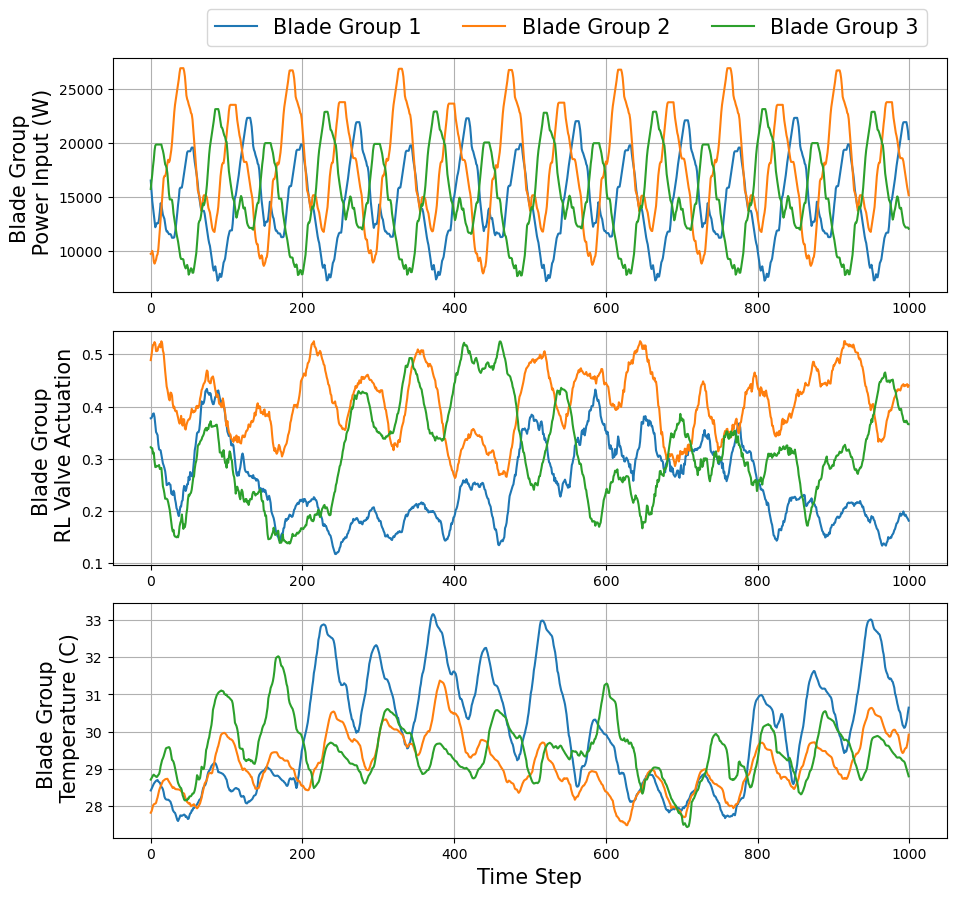

In [31]:
# study correlation between valve actuation and power input and temperature

# plot_upto
plot_from,plot_upto = 1000, 2000

cabinet_num = 2

keys_to_plot = [f'simulator[1].datacenter[1].computeBlock[{cabinet_num}].cabinet[1].boundary_1.port.T',
                f'simulator[1].datacenter[1].computeBlock[{cabinet_num}].cabinet[1].boundary_2.port.T',
                f'simulator[1].datacenter[1].computeBlock[{cabinet_num}].cabinet[1].boundary_3.port.T',
                f'simulator_1_datacenter_1_computeBlock_{cabinet_num}_cabinet_1_sources_ComputePowerBlade1',
                f'simulator_1_datacenter_1_computeBlock_{cabinet_num}_cabinet_1_sources_ComputePowerBlade2',
                f'simulator_1_datacenter_1_computeBlock_{cabinet_num}_cabinet_1_sources_ComputePowerBlade3']
# key_names = ['T_boundary_1', 'T_boundary_2', 'T_boundary_3', 'Power_Blade1', 'Power_Blade2', 'Power_Blade3']
# give meaningful names to keys
key_names = ['Blade Group 1', 'Blade Group 2', 'Blade Group 3']

# plot the data
fig, (ax2, ax3, ax1) = plt.subplots(3, 1, figsize=(10, 9))

# Top subplot
for key,key_legend in zip(keys_to_plot[:3], key_names):
    data = np.array(eval_results_storage.obs_dict[f'cdu-cabinet-{cabinet_num}'][key])-273.15
    data = smooth_array(data, smoothing_kernel_size=50)
    # fitler outliers
    mean = np.mean(data)
    std = np.std(data)
    threshold = 2 * std
    filtered_data = data[(data >= mean - threshold) & (data <= mean + threshold)]
    ax1.plot(filtered_data[plot_from:plot_upto], label=key_legend)
    ax1.set_ylabel('Blade Group \n Temperature (C)', fontsize=15)
# ax1.legend(loc='lower right', fontsize=15, ncol=1)
ax1.grid()
ax1.set_xlabel('Time Step', fontsize=15)

# Medium subplot
for key,key_legend in zip(keys_to_plot[3:], key_names):
    data = np.array(eval_results_storage.obs_dict[f'cdu-cabinet-{cabinet_num}'][key])
    data = smooth_array(data, smoothing_kernel_size=50)
    # fitler outliers
    mean = np.mean(data)
    std = np.std(data)
    threshold = 2 * std
    filtered_data = data[(data >= mean - threshold) & (data <= mean + threshold)]
    ax2.plot(filtered_data[plot_from:plot_upto], label=key_legend)
    ax2.set_ylabel('Blade Group \n Power Input (W)', fontsize=15)
ax2.legend(loc='upper left', fontsize=15, ncol=3, bbox_to_anchor=(0.1, 1.25))
ax2.grid()

# Bottom subplot
values_to_plot = [f'simulator_1_datacenter_1_computeBlock_{cabinet_num}_cabinet_1_sources_Valve_Stpts[1]',
  f'simulator_1_datacenter_1_computeBlock_{cabinet_num}_cabinet_1_sources_Valve_Stpts[2]',
  f'simulator_1_datacenter_1_computeBlock_{cabinet_num}_cabinet_1_sources_Valve_Stpts[3]']
val_names = ['Valve_Stpt_1', 'Valve_Stpt_2', 'Valve_Stpt_3']
for key,key_legend in zip(values_to_plot, key_names):
    data = np.array(eval_results_storage.act_dict[f'cdu-cabinet-{cabinet_num}'][key])
    data = smooth_array(data, smoothing_kernel_size=50)
    # fitler outliers
    mean = np.mean(data)
    std = np.std(data)
    threshold = 2 * std
    filtered_data = data[(data >= mean - threshold) & (data <= mean + threshold)]
    ax3.plot(filtered_data[plot_from:plot_upto], label=key_legend)
    ax3.set_ylabel('Blade Group \n RL Valve Actuation', fontsize=15)
# ax3.legend(loc='lower right', fontsize=15, ncol=3)
ax3.grid()

plt.tight_layout()
# add subtitle
#ax2.set_title(f'Cabinet {cabinet_num} Branch Temperature, Input Power and Valve Actuation Time Series', fontsize=15)
#plt.show()
plt.savefig(f'Cabinet_{cabinet_num}_Branch_Temperature_Input_Power_and_Valve_Actuation_Time_Series.pdf', dpi=300, bbox_inches='tight')

In [ ]:
# store obs dict
obs_df_dict = {}
for key,val in eval_results_storage.obs_dict.items():
    obs_df_dict[key] = pd.DataFrame.from_dict(val)

# store act dict
act_df_dict = {}
for key,val in eval_results_storage.act_dict.items():
    act_df_dict[key] = pd.DataFrame.from_dict(val)
    
# store rl CT setpoint
rl_stpt_df = pd.DataFrame(eval_results_storage.rl_CT_setpoint, columns=['RL_CT_Setpoint'])

# save all three to csv
obs_df = pd.concat(obs_df_dict.values(), axis=1)
obs_df.to_csv(f'obs_df_v{version}.csv', index=False)
act_df = pd.concat(act_df_dict.values(), axis=1)
act_df.to_csv(f'act_df_v{version}.csv', index=False)
rl_stpt_df.to_csv(f'rl_stpt_df_v{version}.csv', index=False)

In [ ]:
# capturing both linear and non-linear relationships.
mi = mutual_info_score(power_data, valve_data)
# mi = mutual_info_score(valve_data, power_data)
print("Mutual Information:", mi)

In [ ]:
# scale each of the power and valve data to be between -1 and 1 and then do the corerelation
power_data_scaled = (power_data - np.min(power_data)) / (np.max(power_data) - np.min(power_data)) * 2 - 1
valve_data_scaled = (valve_data - np.min(valve_data)) / (np.max(valve_data) - np.min(valve_data)) * 2 - 1

cross_corr = correlate(power_data_scaled[:2500], valve_data_scaled[:2500], mode='full')
# plot the cross correlation
plt.figure(figsize=(7, 3))
plt.plot(cross_corr)
plt.title('Cross Correlation between Power Input and Valve Actuation')
plt.xlabel('Lag')
plt.ylabel('Cross Correlation')
plt.grid()
#plt.show()
plt.savefig(f'cross_corr_v{cabinet_num}.pdf', dpi=300, bbox_inches='tight')